#This project predicts customer churn for a telecom company using the Telco Customer Churn dataset. We used various machine learning models, including Logistic Regression, KNN, and a Pytorch Neural Network.

##Import and install dependencies

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim

##Download data into github and read into a dataframe, the data is originally from https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [207]:
df = pd.read_csv('https://raw.githubusercontent.com/Md905908324/data_bootcamp_final/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [208]:
df = df.drop(['customerID'], axis=1) #drop id
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce') #make total charges float
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}) #make churn binary
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'}) #make senior yes or no for visualization
df.dropna(inplace=True) #remove any na

In [209]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [210]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,0.265785
std,24.545260,30.085974,2266.771362,0.441782
min,1.000000,18.250000,18.800000,0.000000
25%,9.000000,35.587500,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.862500,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [212]:
for col in df.select_dtypes(include=['object']).columns: #find all possible values for all columns
  print(df[col].value_counts())
  print("\n")

gender
Male      3549
Female    3483
Name: count, dtype: int64


SeniorCitizen
No     5890
Yes    1142
Name: count, dtype: int64


Partner
No     3639
Yes    3393
Name: count, dtype: int64


Dependents
No     4933
Yes    2099
Name: count, dtype: int64


PhoneService
Yes    6352
No      680
Name: count, dtype: int64


MultipleLines
No                  3385
Yes                 2967
No phone service     680
Name: count, dtype: int64


InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64


OnlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: count, dtype: int64


OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: count, dtype: int64


DeviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: count, dtype: int64


TechSupport
No                     3472
Yes                    2040
No internet

###The dataset includes 7043 customers and features:

Demographics: Gender, Senior Citizen, Partner, Dependents

Services: Phone Service, Multiple Lines, Internet Service, Online Security, Backup, Device Protection, Tech Support, Streaming TV/Movies

Account Info: Tenure, Contract, Paperless Billing, Payment Method, Monthly & Total Charges

Target: Churn (Yes/No)

##Here is some basic data visualization

<ipython-input-213-e7cc20c36c00>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col_idx].set_xticklabels(['No', 'Yes']) #make senior citizen


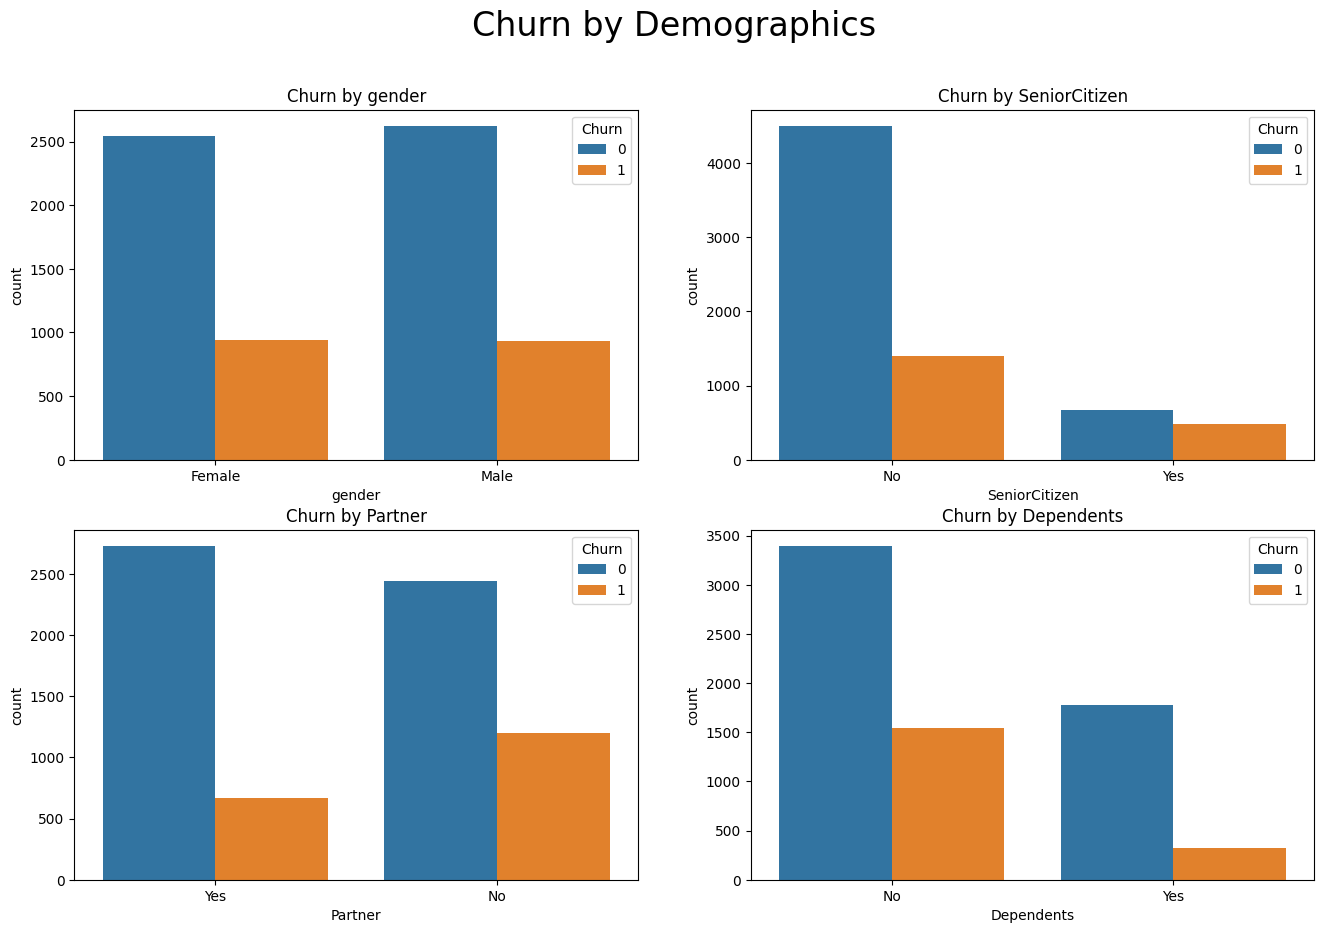

In [213]:
# Demographic features
demo_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig, axes = plt.subplots(2, 2, figsize=(16, 10)) # 2x2 subplot grid
fig.suptitle('Churn by Demographics', fontsize=24)

for i, col in enumerate(demo_cols): #make a subplot for each feature
    row = i // 2
    col_idx = i % 2
    sns.countplot(ax=axes[row, col_idx], x=col, hue='Churn', data=df)
    axes[row, col_idx].set_title(f'Churn by {col}')
    if col == 'SeniorCitizen':
        axes[row, col_idx].set_xticklabels(['No', 'Yes']) #make senior citizen
plt.show()

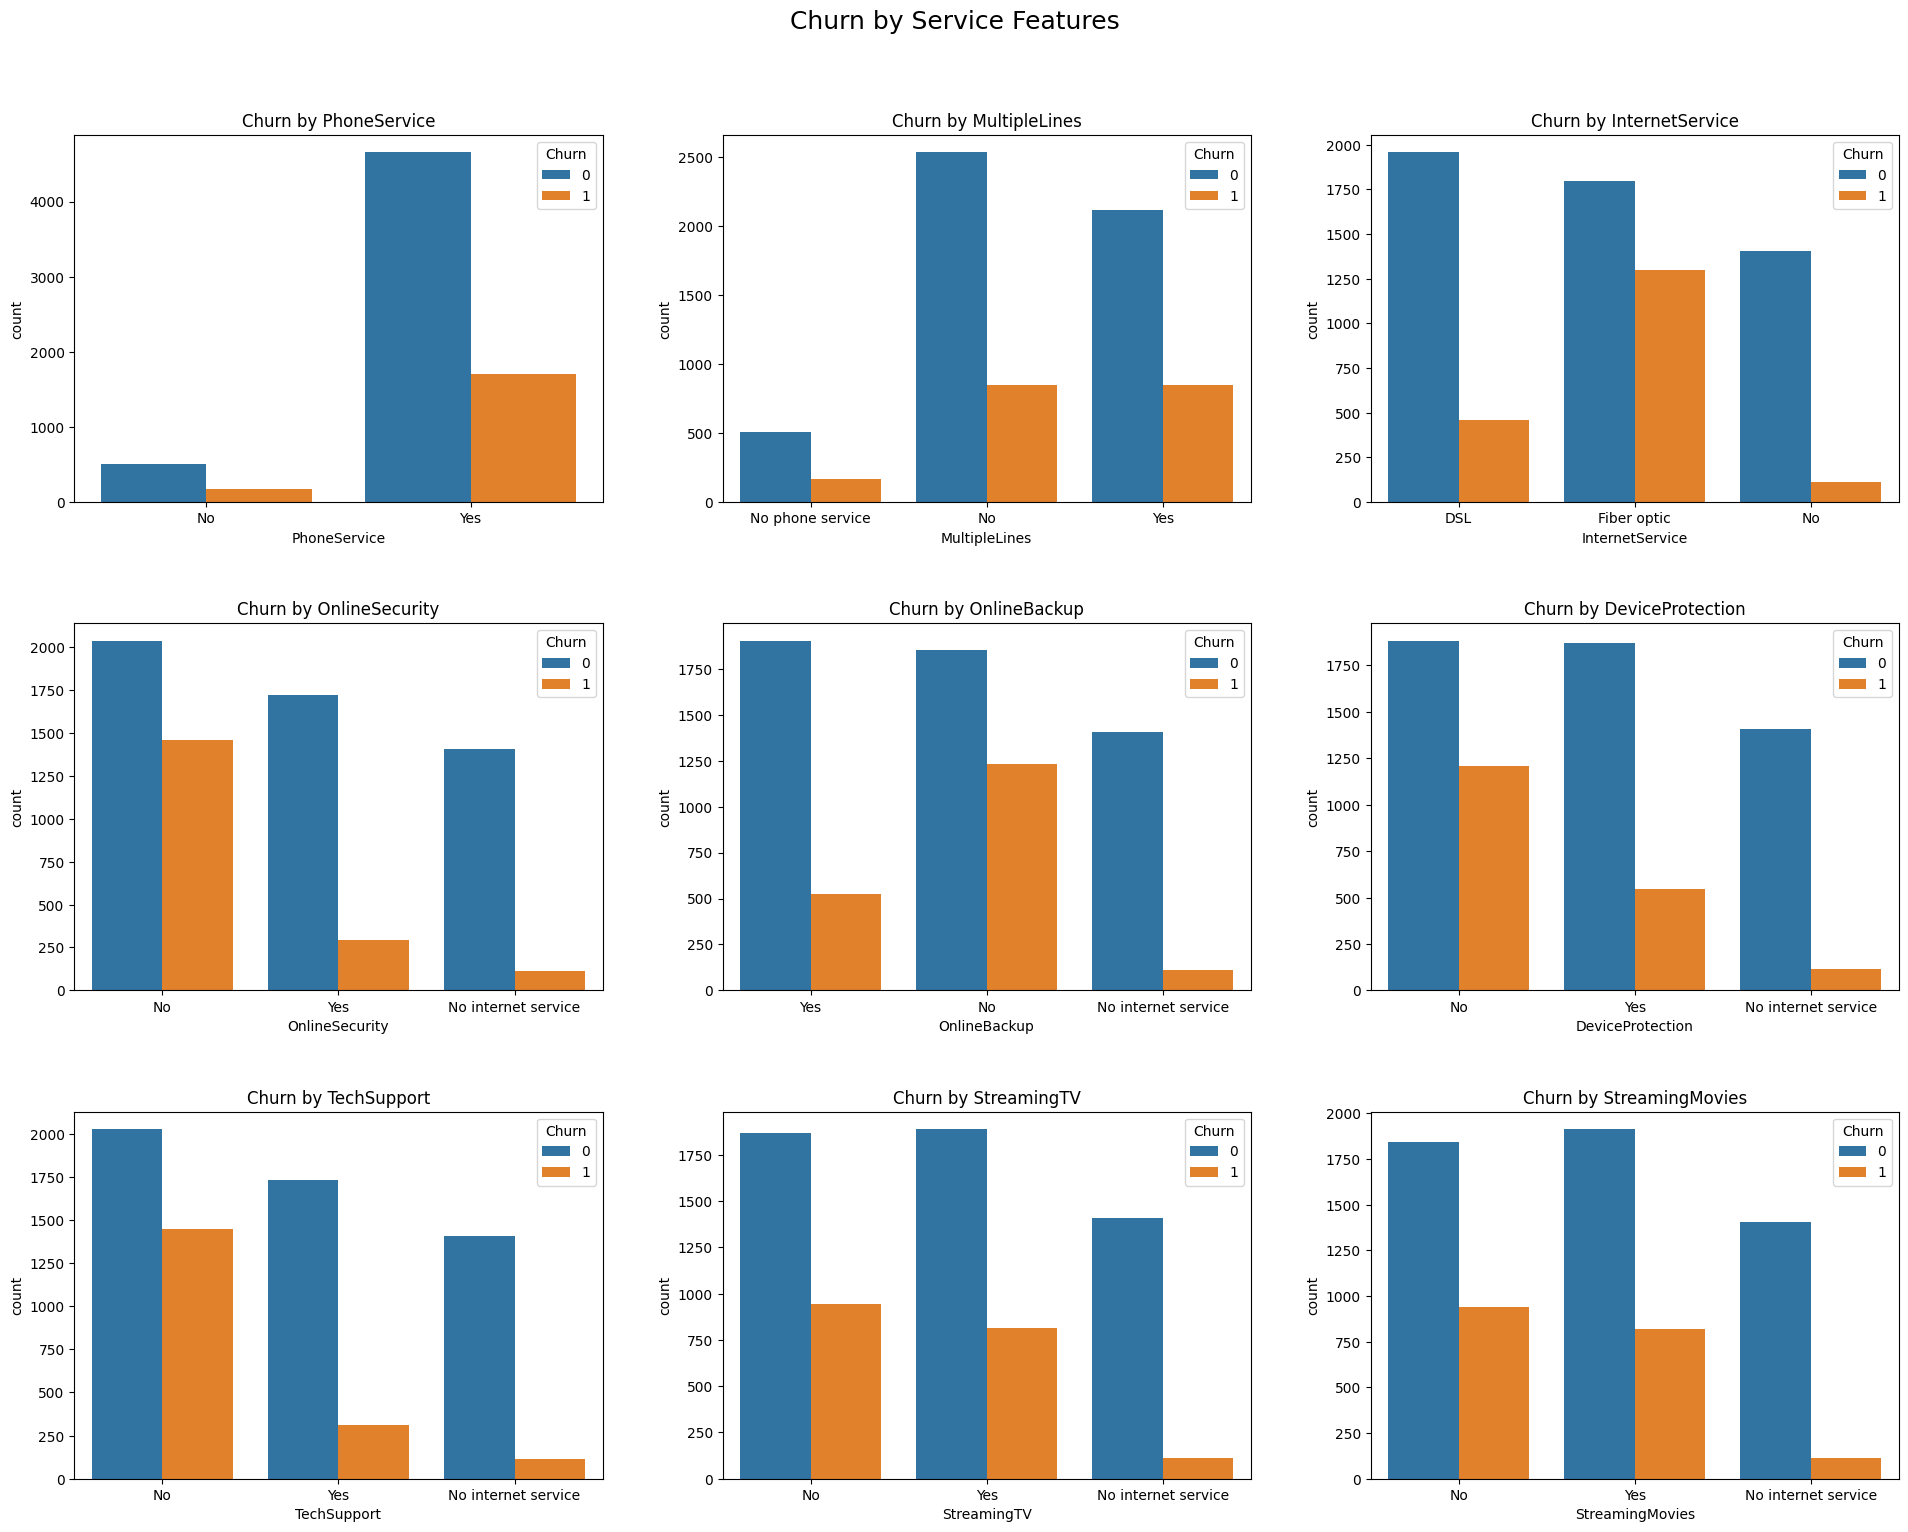

In [214]:
#Service-related features
service_cols = [
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

fig, axes = plt.subplots(3, 3, figsize=(20, 16)) # 3x3 subplot grid
fig.suptitle('Churn by Service Features', fontsize=18)

for i, col in enumerate(service_cols): #plot each service feature
    row = i // 3
    col_index = i % 3
    sns.countplot(ax=axes[row, col_index], x=col, hue='Churn', data=df)
    axes[row, col_index].set_title(f'Churn by {col}')

plt.tight_layout(pad = 4)
plt.show()

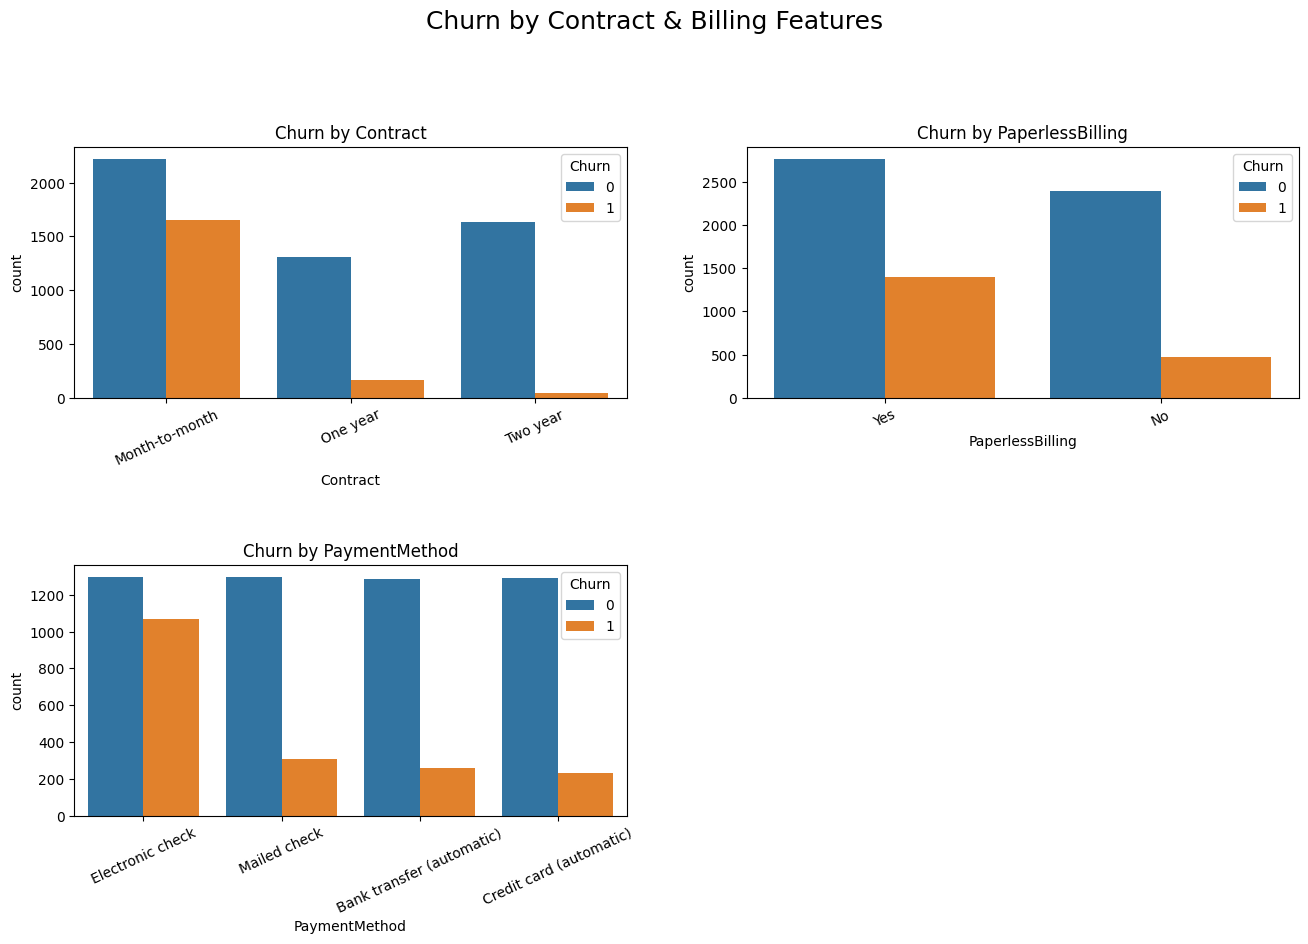

In [215]:
#Finance features
finance_cols = ['Contract', 'PaperlessBilling', 'PaymentMethod']
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) #2x2 with one empty
fig.suptitle('Churn by Contract & Billing Features', fontsize=18)

for i, col in enumerate(finance_cols): #subplots for each feature
    row = i // 2
    col_idx = i % 2
    sns.countplot(ax=axes[row, col_idx], x=col, hue='Churn', data=df)
    axes[row, col_idx].set_title(f'Churn by {col}')
    axes[row, col_idx].tick_params(axis='x', rotation=25)

axes[1, 1].axis('off') #remove extra plot
plt.tight_layout(pad = 4)
plt.show()

##Now, moving on to EDA

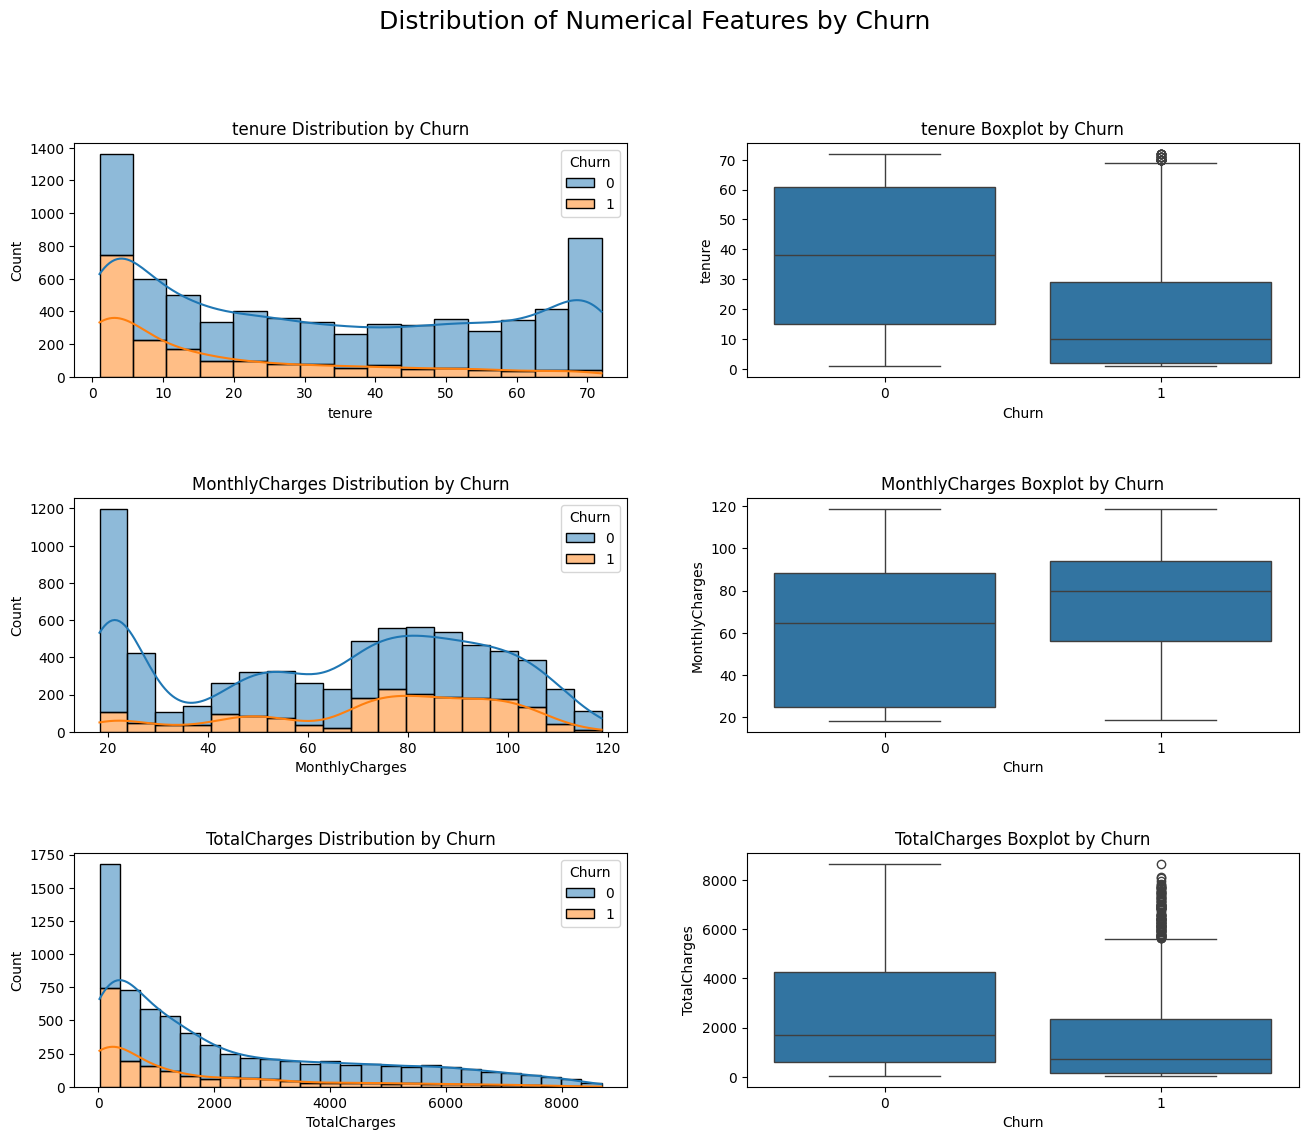

In [216]:
#Numerical features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribution of Numerical Features by Churn', fontsize=18)

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='Churn', ax=axes[i, 0], kde=True, multiple='stack')  # Histogram with hue by churn
    axes[i, 0].set_title(f'{col} Distribution by Churn')
    sns.boxplot(data=df, x='Churn', y=col, ax=axes[i, 1]) #box plot
    axes[i, 1].set_title(f'{col} Boxplot by Churn')
plt.tight_layout(pad = 4)
plt.show()


In [217]:
#quickly map all yes and no into binary
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1}) #male = 0, female = 1

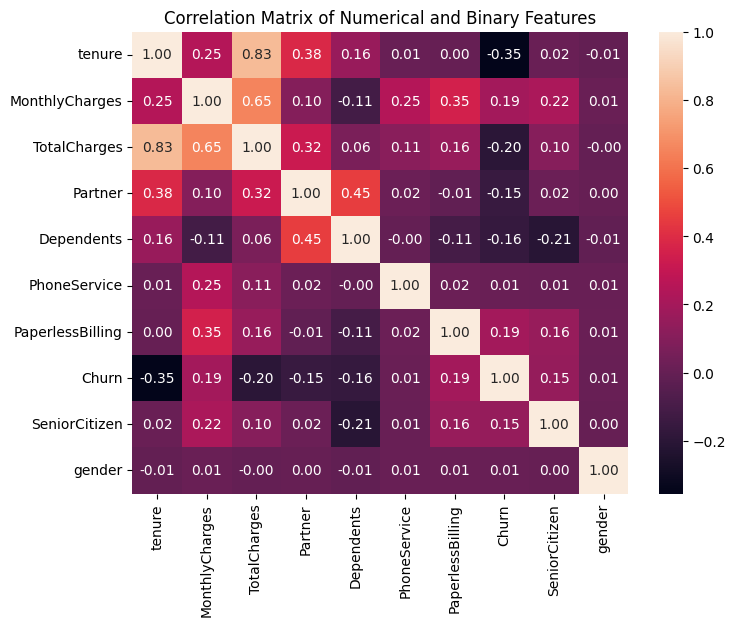

In [218]:
#correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'SeniorCitizen', 'gender']].corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numerical and Binary Features')
plt.show()

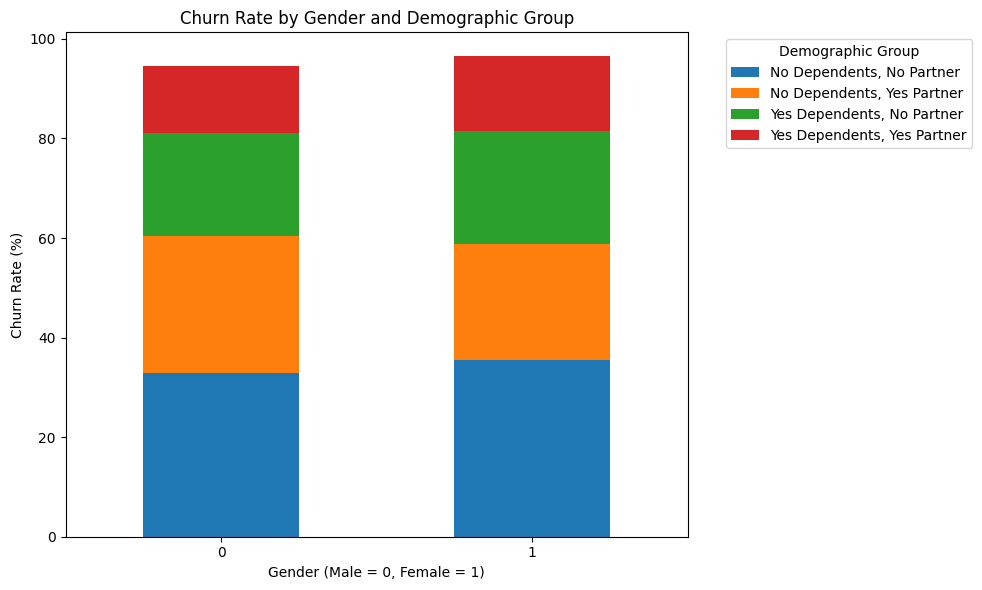

In [219]:
# Map and plot Dependents_Partner to see significance of household structures on churn
df['Dependents_Partner'] = df['Dependents'].astype(str) + '_' + df['Partner'].astype(str)

dp_map = {
    '0_1': 'No Dependents, Yes Partner',
    '1_1': 'Yes Dependents, Yes Partner',
    '0_0': 'No Dependents, No Partner',
    '1_0': 'Yes Dependents, No Partner'
}

df['Dependents_Partner'] = df['Dependents_Partner'].map(dp_map) #make new col based on dependents and partner
grouped = df.groupby(['gender', 'Dependents_Partner'])['Churn'].agg(['count', 'sum']).reset_index()
grouped['churn_rate'] = grouped['sum'] / grouped['count'] * 100 #calculate churn rate
pivoted = grouped.pivot(index='gender', columns='Dependents_Partner', values='churn_rate') #pivot data to plot

pivoted.plot(kind='bar', stacked=True, figsize=(10, 6)) # Plot data
plt.title('Churn Rate by Gender and Demographic Group')
plt.xlabel('Gender (Male = 0, Female = 1)')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)
plt.legend(title='Demographic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

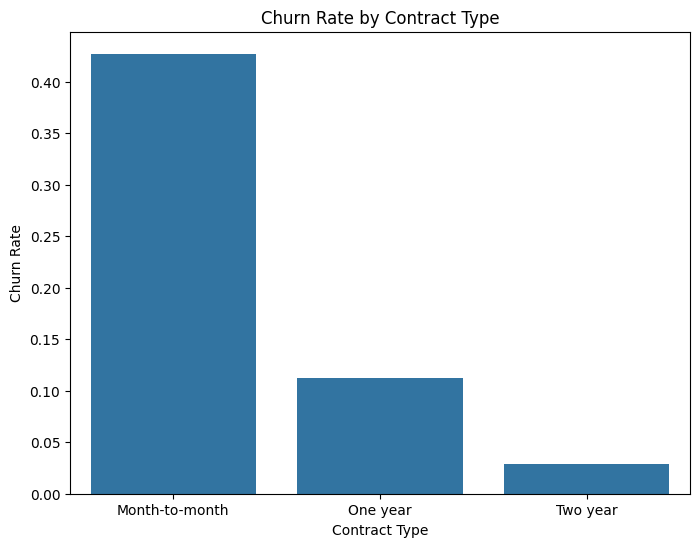

In [220]:
# Group and plot data by Contract term
contract_churn = df.groupby('Contract')['Churn'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Contract', y='Churn', data=contract_churn)
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.show()

In [221]:
df['StreamingService'] = 'None'  # Initialize all to none, and assign values based on streaming tv and movies columns.
df.loc[(df['StreamingTV'] == 'Yes') & (df['StreamingMovies'] == 'Yes'), 'StreamingService'] = 'Both'
df.loc[(df['StreamingTV'] == 'Yes') & (df['StreamingMovies'] == 'No'), 'StreamingService'] = 'TV'
df.loc[(df['StreamingTV'] == 'No') & (df['StreamingMovies'] == 'Yes'), 'StreamingService'] = 'Movies'

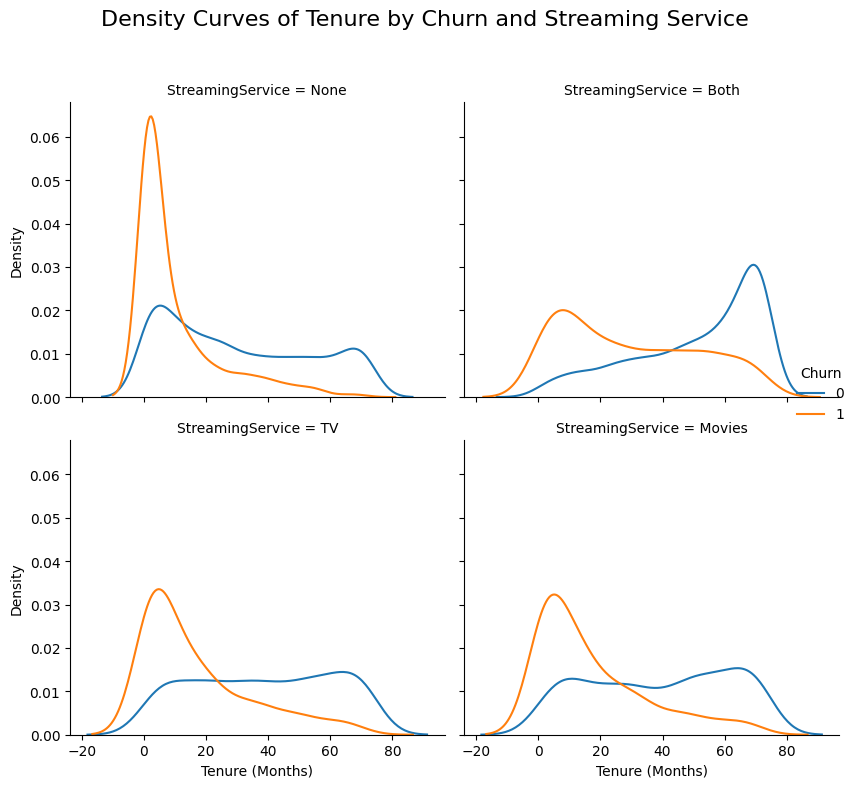

In [222]:
# Make a facet grid for each of the streaming services combinations
g = sns.FacetGrid(df, col="StreamingService", hue="Churn", col_wrap=2, height=4)
g.map(sns.kdeplot, "tenure", common_norm=False) #map the density curves
g.add_legend()
g.fig.suptitle('Density Curves of Tenure by Churn and Streaming Service', fontsize=16)
g.set_xlabels('Tenure (Months)')
g.set_ylabels('Density')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

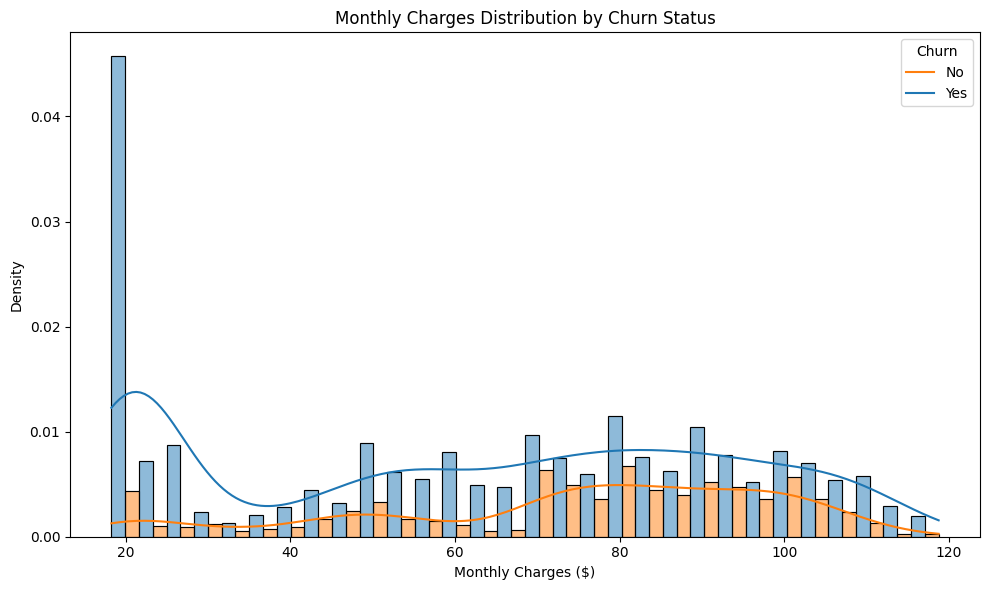

In [223]:
#Determining the effects of monthly charges on Churn rate.
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, stat='density', bins=30, multiple="dodge")

plt.title('Monthly Charges Distribution by Churn Status')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Density')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

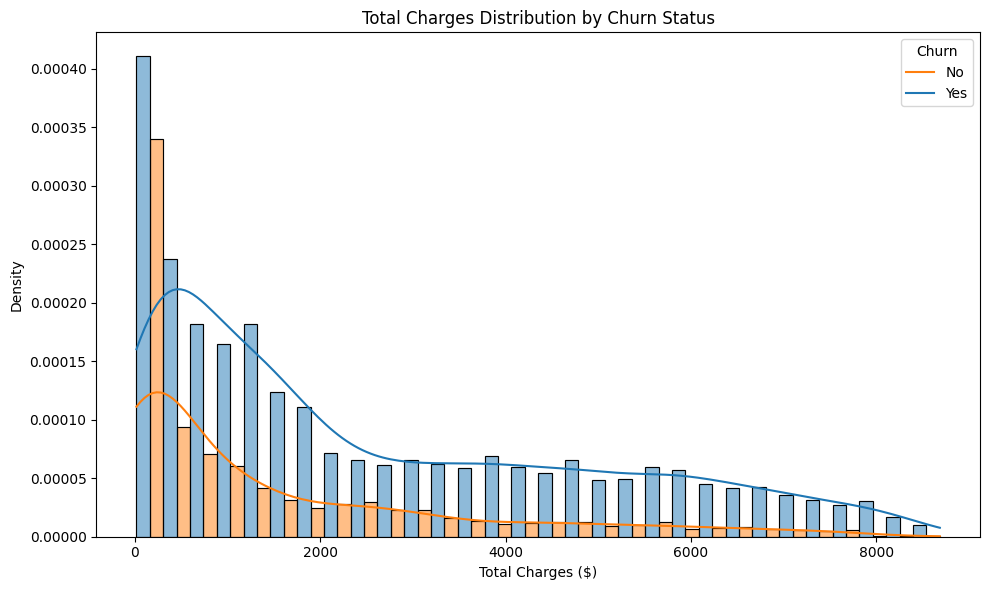

In [224]:
#Determining the effects of total charges on Churn rate.
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TotalCharges', hue='Churn', kde=True, stat='density', bins=30, multiple="dodge")

plt.title('Total Charges Distribution by Churn Status')
plt.xlabel('Total Charges ($)')
plt.ylabel('Density')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

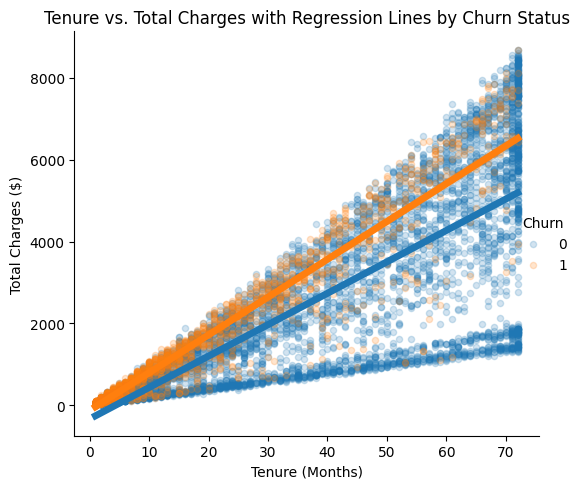

In [225]:
#Now, since both tenure and total charges accumulate over time, we can plot them against each other to see for a pattern
plt.figure(figsize=(10, 6))
sns.lmplot(data=df, x='tenure', y='TotalCharges', hue='Churn', scatter_kws={'alpha':0.2, 's':20}, line_kws={'linewidth': 5})
plt.title('Tenure vs. Total Charges with Regression Lines by Churn Status')
plt.xlabel('Tenure (Months)')
plt.ylabel('Total Charges ($)')
plt.tight_layout()
plt.show()

Knowing that there is a difference in churn rates of tenure and total charges ratio, we can plot the average total charges for across different tenure bins, along with the standard deviation.


  tenure_bins  Churn         mean         std
0        0-10      0   203.060054  195.022677
1        0-10      1   220.148104  212.430838
2       10-20      0   740.755910  437.404985
3       10-20      1  1073.207258  382.925946
4       20-30      0  1382.532594  711.318741


<ipython-input-226-d962edf5381f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['tenure_bins', 'Churn'])['TotalCharges'].agg(['mean', 'std']).reset_index() #gorup by tenure and churn to find mean


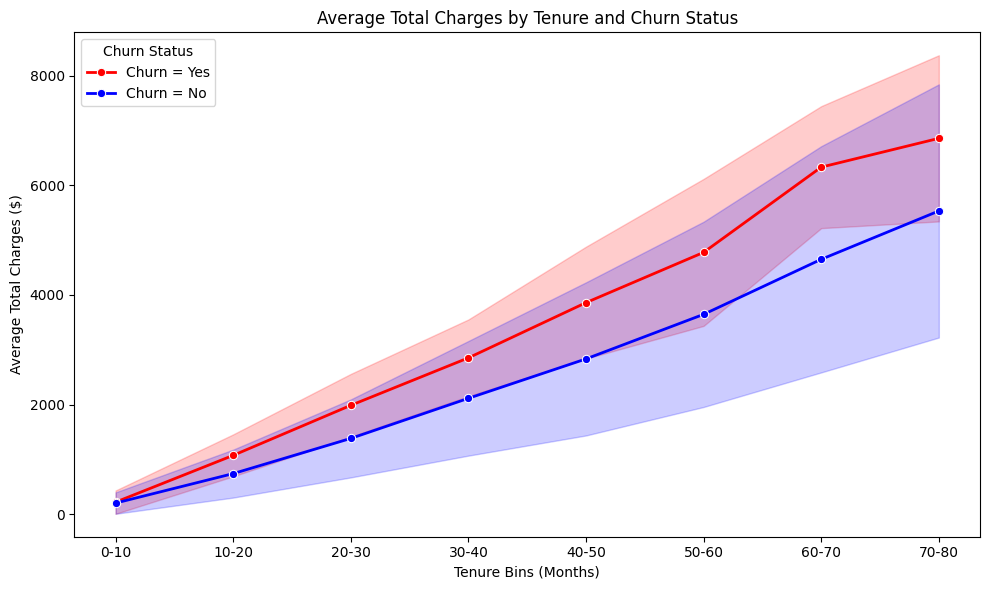

In [226]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]  # Bins for tenure
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
df['tenure_bins'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)
grouped = df.groupby(['tenure_bins', 'Churn'])['TotalCharges'].agg(['mean', 'std']).reset_index() #gorup by tenure and churn to find mean
print(grouped.head()) #show data for each bin and stats
plt.figure(figsize=(10, 6))

sns.lineplot(data=grouped[grouped['Churn'] == 1], x='tenure_bins', y='mean', label='Churn = Yes', marker='o', color='red', linewidth=2) # Yes Churn line plot with mean and shaded standard deviation
plt.fill_between(grouped[grouped['Churn'] == 1]['tenure_bins'],
                 grouped[grouped['Churn'] == 1]['mean'] - grouped[grouped['Churn'] == 1]['std'],
                 grouped[grouped['Churn'] == 1]['mean'] + grouped[grouped['Churn'] == 1]['std'],
                 color='red', alpha=0.2)

sns.lineplot(data=grouped[grouped['Churn'] == 0], x='tenure_bins', y='mean', label='Churn = No', marker='o', color='blue', linewidth=2) # No churn line plot with mean and shaded standard deviation
plt.fill_between(grouped[grouped['Churn'] == 0]['tenure_bins'],
                 grouped[grouped['Churn'] == 0]['mean'] - grouped[grouped['Churn'] == 0]['std'],
                 grouped[grouped['Churn'] == 0]['mean'] + grouped[grouped['Churn'] == 0]['std'],
                 color='blue', alpha=0.2)

plt.title('Average Total Charges by Tenure and Churn Status') #plot
plt.xlabel('Tenure Bins (Months)')
plt.ylabel('Average Total Charges ($)')
plt.legend(title='Churn Status')
plt.tight_layout()
plt.show()

##Moving on to machine learning, starting with OHE +

In [227]:
ml1_df = df.copy() #make a copy of ml
ml1_df = ml1_df.drop(['Dependents_Partner', 'tenure_bins', 'StreamingService'], axis=1)
ml1_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,1,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,1,Mailed check,84.80,1990.50,0
7039,1,0,1,1,72,1,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,1,Credit card (automatic),103.20,7362.90,0
7040,1,0,1,1,11,0,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,1,Electronic check,29.60,346.45,0
7041,0,1,1,0,4,1,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Mailed check,74.40,306.60,1


In [228]:
ml1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   object 
 17  

In [229]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

In [230]:
numerical_transformer = Pipeline(steps=[ #scale numeric with standard scaler
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  #scale categorical with ohe
])

In [231]:
preprocessor = ColumnTransformer( #use column transformer to combine the two transformers
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipeline_logreg = Pipeline(steps=[ #make the pipeline for preprocessor and logreg
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [232]:
X1 = ml1_df.drop('Churn', axis=1)
y1 = ml1_df['Churn']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [233]:
pipeline_logreg.fit(X_train1, y_train1) # fit pipeline
y_pred1 = pipeline_logreg.predict(X_test1) #predict
accuracy1 = accuracy_score(y_test1, y_pred1)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test1, y_pred1))

Accuracy: 0.8259555555555556
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



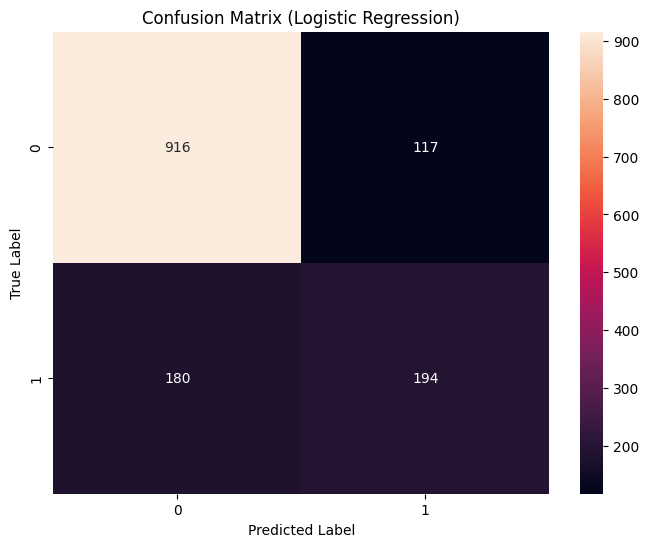

In [234]:
# Make a confusion matrix for lin reg
cm1 = confusion_matrix(y_test1, y_pred1)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d")
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

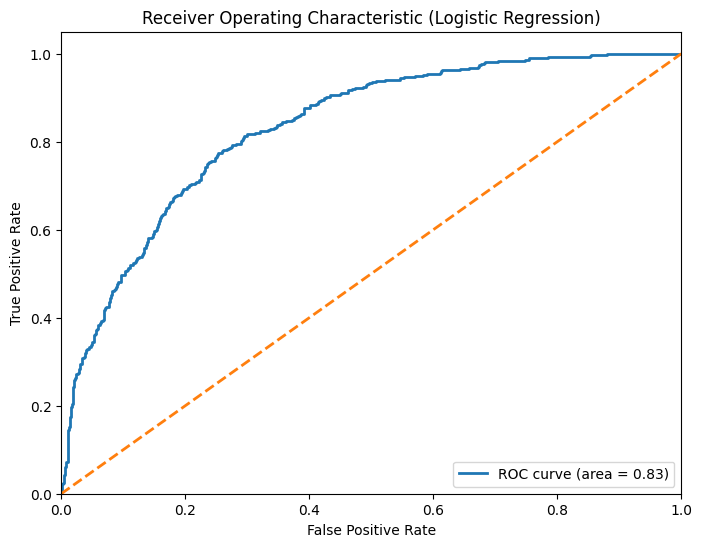

In [235]:
# Now, an ROC curve
y_probs1 = pipeline_logreg.predict_proba(X_test1)[:, 1]  # Probability of class 1 (Churn)
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_probs1) #calculate roc curve
roc_auc1 = roc_auc_score(y_test1, y_probs1) #calculate auc

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, lw=2, label=f'ROC curve (area = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

###With Logistic Regression, we got 78.9% accuraccy and .52 churn recall. The ROC area shows a good performance on the model. Next, lets try using KNN.

In [236]:
#same stuff as above, the preprocessing will be the same.
ml2_df = df.copy()
ml2_df = ml2_df.drop(['Dependents_Partner', 'tenure_bins', 'StreamingService'], axis=1)
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  #Changed to knn instead of logreg
])
X2 = ml2_df.drop('Churn', axis=1)
y2 = ml2_df['Churn']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [237]:
pipeline_knn.fit(X_train2, y_train2)
y_pred2 = pipeline_knn.predict(X_test2)
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy (KNN): {accuracy2}")
print(classification_report(y_test2, y_pred2))

Accuracy (KNN): 0.749822316986496
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1033
           1       0.53      0.50      0.52       374

    accuracy                           0.75      1407
   macro avg       0.68      0.67      0.67      1407
weighted avg       0.75      0.75      0.75      1407



###With only 5 n neighbors, we only have 75% accuracy with 50% recall, so we should do grid search to find optimal knn.

In [238]:
param_grid = {'classifier__n_neighbors': range(1, 31)}
grid_search = GridSearchCV(pipeline_knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train2, y_train2)
best_n_neighbors = grid_search.best_params_['classifier__n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

Best n_neighbors: 18


In [239]:
pipeline_knn_best = Pipeline(steps=[ #make a best with new n neighbors = best n neighbors
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(best_n_neighbors))  #Changed to knn instead of logreg
])

In [240]:
pipeline_knn_best.fit(X_train2, y_train2) #fit data, same as above
y_pred2 = pipeline_knn_best.predict(X_test2)
accuracy2 = accuracy_score(y_test2, y_pred2)
print(f"Accuracy (KNN): {accuracy2}")
print(classification_report(y_test2, y_pred2))

Accuracy (KNN): 0.7789623312011372
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.60      0.52      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



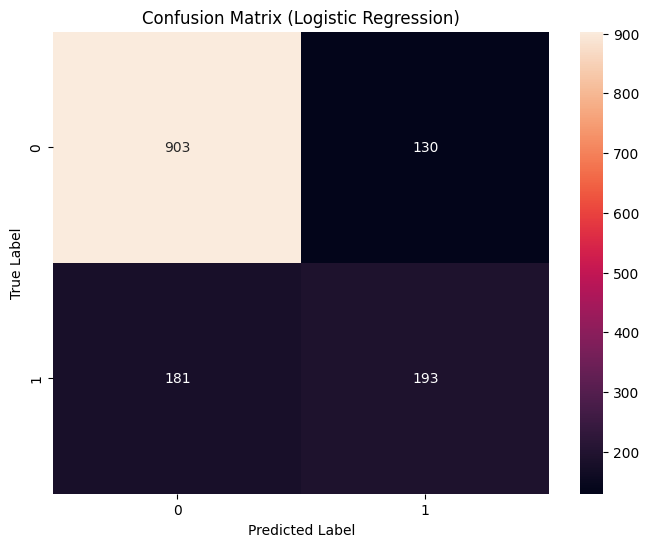

In [241]:
# Make a confusion matrix for knn, same as above
cm2 = confusion_matrix(y_test2, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d")
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

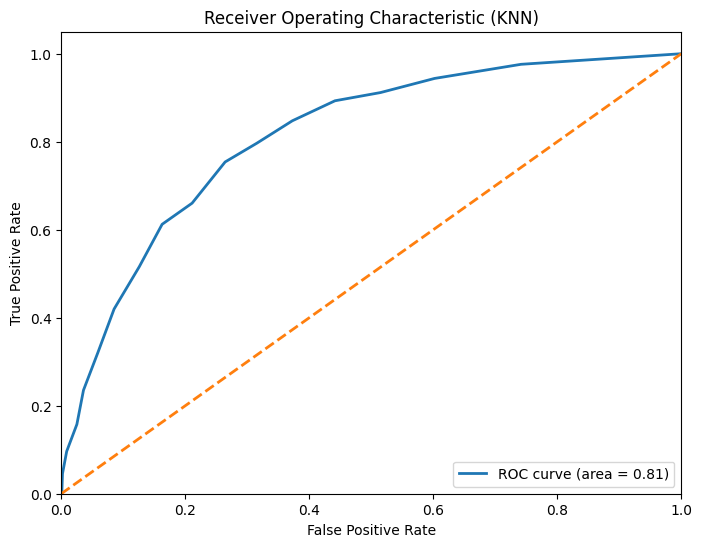

In [242]:
y_probs2 = pipeline_knn_best.predict_proba(X_test2)[:, 1]  # Prob of churn, same as above for logreg
fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_probs2) #  ROC curve
roc_auc2 = roc_auc_score(y_test2, y_probs2) #calculate auc

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, lw=2, label=f'ROC curve (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (KNN)')
plt.legend(loc="lower right")
plt.show()

###So we ended with 77.89% accuracy with 52% recall for churn again, the same for logreg. ROC area is .81, which is also good. That means both models are performing relatively well. Next, lets try if pytorch's neural networks give something better.

In [243]:
ml3_df = df.copy() #copy and preprocess data, similar to above.
ml3_df = ml3_df.drop(['Dependents_Partner', 'tenure_bins', 'StreamingService'], axis=1)
X3 = ml3_df.drop('Churn', axis=1)
y3 = ml3_df['Churn']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_train3_processed = preprocessor.fit_transform(X_train3) #use preprocessor directly instead
X_test3_processed = preprocessor.transform(X_test3)

In [244]:
#make pytorch tensors from train and test data
X_train_tensor = torch.tensor(X_train3_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train3.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test3_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test3.values, dtype=torch.float32).reshape(-1, 1)

In [245]:
class ChurnPredictionModel(nn.Module): #make the prediction model
    def __init__(self, input_size):
        super(ChurnPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) #first layer input into 64 units
        self.fc2 = nn.Linear(64, 32) #second layer with 32
        self.fc3 = nn.Linear(32, 1) #output 1 unit
        self.sigmoid = nn.Sigmoid() #use sigmond since churn binary

    def forward(self, x): #use relu on the first 2 layers and then sigmond on the output
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [253]:
model3 = ChurnPredictionModel(input_size=X_train_tensor.shape[1]) #make a instance with the model
optimizer = optim.Adam(model3.parameters()) #use an adam optimizer instead of SGD since it is faster
criteria = nn.BCELoss() #use bceloss as criteria

After some trial and error, 300 seem to be a good number of epochs for accurate data.

In [254]:
num_epochs = 300
losses = []
accuracy_scores = []
test_accuracy_scores = []

for epoch in range(num_epochs):
    outputs = model3(X_train_tensor)
    loss = criteria(outputs, y_train_tensor) #calculate loss
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward() #calculate gradients to minimize loss
    optimizer.step() #update

    with torch.no_grad(): #train accuracy
        predicted = (outputs > 0.5).float() # convert probabilities to binary predictions
        accuracy = (predicted == y_train_tensor).sum().item() / y_train_tensor.size(0) #calculate accuracy
        accuracy_scores.append(accuracy)

    with torch.no_grad(): #test accuracy
        outputs_test = model3(X_test_tensor)  # Pass test data through the model
        predicted_test = (outputs_test > 0.5).float()  # Convert probabilities to binary predictions
        accuracy_test = (predicted_test == y_test_tensor).sum().item() / y_test_tensor.size(0)  # Calculate accuracy
        test_accuracy_scores.append(accuracy_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {accuracy:.4f}, Test Accuracy: {accuracy_test:.4f}')

Epoch [1/300], Loss: 0.6816, Train Accuracy: 0.7044, Test Accuracy: 0.7313
Epoch [2/300], Loss: 0.6764, Train Accuracy: 0.7323, Test Accuracy: 0.7342
Epoch [3/300], Loss: 0.6714, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [4/300], Loss: 0.6665, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [5/300], Loss: 0.6618, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [6/300], Loss: 0.6570, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [7/300], Loss: 0.6522, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [8/300], Loss: 0.6473, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [9/300], Loss: 0.6423, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [10/300], Loss: 0.6371, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [11/300], Loss: 0.6317, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [12/300], Loss: 0.6262, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [13/300], Loss: 0.6206, Train Accuracy: 0.7342, Test Accuracy: 0.7342
Epoch [14/300], Loss:

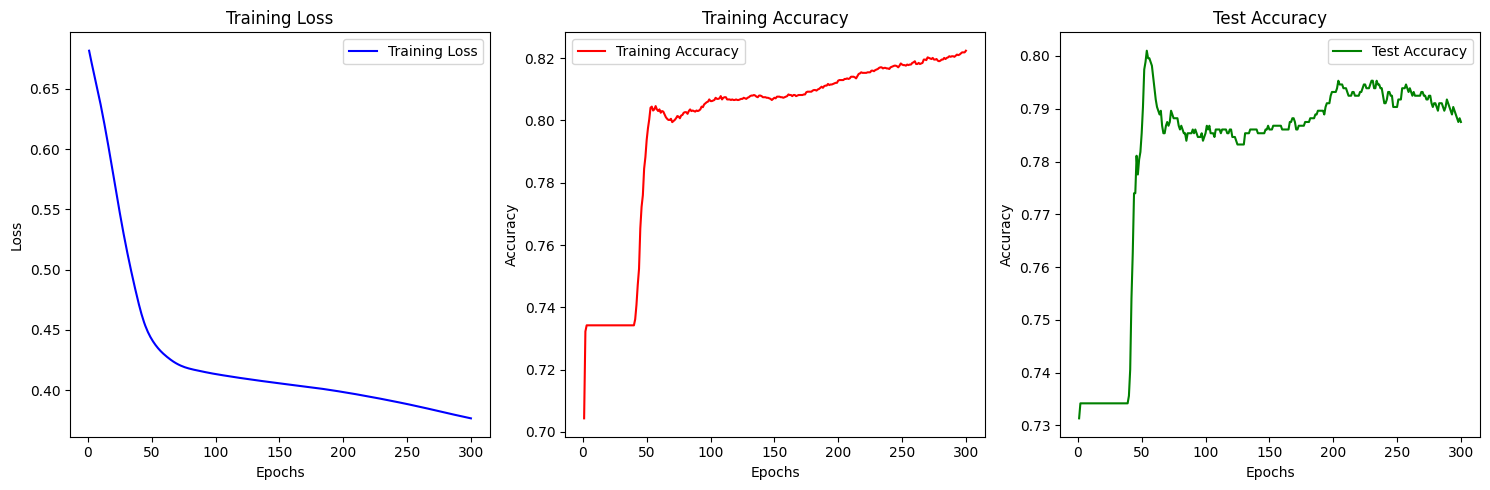

In [255]:
# Plot the Loss and Both Accuracy Curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5)) #loss curve
plt.subplot(1, 3, 1)
plt.plot(epochs, losses, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2) #train accuracy
plt.plot(epochs, accuracy_scores, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)  # Test accuracy
plt.plot(epochs, test_accuracy_scores, 'g', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [257]:
with torch.no_grad(): #final accuracy at 300 epochs
    outputs = model3(X_test_tensor)
    predicted = (outputs > 0.5).float()
    accuracy3 = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on test set: {accuracy3:.4f}')
    print(classification_report(y_test_tensor, predicted))

Accuracy on test set: 0.7875
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      1033
         1.0       0.61      0.54      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



Even for neural networks, the accuracy on test set is 78.75, and churn recall is 54%, which is still similar to the previous two models.

##We evaluated three models (Logistic Regression, KNN, and a Neural Network) to predict telecom customer churn. After preprocessing and model training, we assessed performance using accuracy, precision, recall, confusion matrixes, and ROC curves.

In [259]:
print(f"Accuracy (Logistic Regression): {accuracy1:.4f}")
print(f"Accuracy (KNN): {accuracy2:.4f}")
print(f"Accuracy (Neural Network): {accuracy3:.4f}")

Accuracy (Logistic Regression): 0.7889
Accuracy (KNN): 0.7790
Accuracy (Neural Network): 0.7875


###The Neural Network (at optimal epochs) outperformed other models by only a very slight margin. For future scaling, we can focus on improving feature engineering and using more advanced neural network structures. Also, the neural network used was relatively simple, and minimal hyperparameter tuning was performed, so we can improve that to potentially enhance the model.